# Checking Reflected Spectra Grid Clouds
- Looks like it works properly in calculating clouds!

In [1]:
import GraphsKey
import numpy as np
import FilterGrids
import Reflected_Spectra_grid as Reflected_Spectra
import PICASO_Climate_grid
import Photochem_grid
import h5py

import picaso.justdoit as jdi
import picaso.justplotit as jpi
import copy
import pandas as pd

from scipy import optimize
from matplotlib import pyplot as plt

## First Check Reflected Spectra Grid Handles Clouds Properly

In [2]:
filename='results/ReflectedSpectra_fv.h5'
gridvals=Reflected_Spectra.get_gridvals_RSM()

gridvals_metal = [float(s) for s in gridvals[1]]
gridvals_dict = {'total_flux':gridvals[0], 'planet_metallicity':np.array(gridvals_metal), 'tint':gridvals[2], 'kzz':gridvals[3], 'phase':gridvals[4]}
index_flux = np.linspace(0, len(gridvals_dict['total_flux']) - 1, len(gridvals_dict['total_flux']), dtype=int)
print(gridvals_dict['total_flux'], index_flux)
index_metal = np.linspace(0, len(gridvals_dict['planet_metallicity']) - 1, len(gridvals_dict['planet_metallicity']), dtype=int)
print(gridvals_dict['planet_metallicity'], index_metal)
index_tint = np.linspace(0, len(gridvals_dict['tint']) - 1, len(gridvals_dict['tint']), dtype=int)
print(gridvals_dict['tint'], index_tint)
index_kzz = np.linspace(0, len(gridvals_dict['kzz']) - 1, len(gridvals_dict['kzz']), dtype=int)
print(gridvals_dict['kzz'], index_kzz)
index_phase = np.linspace(0, len(gridvals_dict['phase']) - 1, len(gridvals_dict['phase']), dtype=int)
print(gridvals_dict['phase'], index_phase)
true_converg_list = np.array([1])
matching_indicies_clouds = []
matching_values_clouds = []

with h5py.File(filename, 'r') as f:
    
    for flux in index_flux:
        for metal in index_metal:
            for tint in index_tint:
                for kzz in index_kzz:
                    for phase in index_phase:
                        if np.array(list(f['results']['clouds'][flux][metal][tint][kzz][phase]))[0] == true_converg_list:
                            index = np.array([flux, metal, tint, kzz, phase])
                            matching_indicies_clouds.append(index)

    for array in matching_indicies_clouds:
        flux_index = array[0]
        metal_index = array[1]
        tint_index = array[2]
        kzz_index = array[3]
        phase_index = array[4]
        flux_value = gridvals_dict['total_flux'][flux_index]
        metal_value = gridvals_dict['planet_metallicity'][metal_index]
        tint_value = gridvals_dict['tint'][tint_index]
        kzz_value = gridvals_dict['kzz'][kzz_index]
        phase_value = gridvals_dict['phase'][phase_index]
        list_value = [flux_value, metal_value, tint_value, kzz_value, phase_value]
        matching_values_clouds.append(list_value)
        
    
    print(len(matching_indicies_clouds), len(matching_values_clouds))

    print(f'Cases with clouds totaled: {len(matching_values_clouds)}')

[0.1 0.5 1.  1.5 2. ] [0 1 2 3 4]
[0.5 1.  1.5 2. ] [0 1 2 3]
[ 20  40  60 100 120 140 160 200] [0 1 2 3 4 5 6 7]
[5 7 9] [0 1 2]
[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
3456 3456
Cases with clouds totaled: 3456


In [3]:
def find_pbot(pressure=None, H2Oaer=None, tol=0.9):

    """
    Parameters:
    pressures: ndarray
        Pressure at each atmospheric layer in dynes/cm^2
    H2Oaer: ndarray
        Mixing ratio of H2O aerosols.
    tol: float, optional
        The threshold value for which we define the beginning of the cloud, 
        by default 1e-4. 

    Returns:
    P_bottom: float
        The cloud bottom pressure in dynes/cm^2
        
    """

    # There is no water cloud in the model, so we return None
    # For the cloud bottom of pressure

    if np.max(H2Oaer) < 1e-20:
        return None

    # Normalize so that max value is 1
    H2Oaer_normalized = H2Oaer/np.max(H2Oaer)

    # loop from bottom to top of atmosphere, cloud bottom pressure
    # defined as the index level where the normalized cloud mixing ratio
    # exeeds tol .

    ind = None
    
    for i, val in enumerate(H2Oaer_normalized):
        if val > tol:
            ind = i
            break

    if ind is None:
        raise Exception('A problem happened when trying to find the bottom of the cloud.')

    # Bottom of the cloud
    pbot = pressure[ind]

    return pbot

In [4]:
def plot_cloud(sol_dict, flux_index, metal_index, tint_index, kzz_index):

    pbot = find_pbot(pressure=sol_dict['pressure'][flux_index][metal_index][tint_index][kzz_index], H2Oaer=sol_dict['H2Oaer'][flux_index][metal_index][tint_index][kzz_index])
    
    # Plot the Composition from Photochem
    fig, ax1 = plt.subplots(1,1,figsize=[5,4])
    species = ['CO2','H2O','CH4','CO','NH3','H2','HCN','H2Oaer']
    #species_sol = ['CO2_sol','H2O_sol','CH4_sol','CO_sol','NH3_sol','H2_sol','HCN_sol','H2Oaer_sol']
    #species_soleq = ['CO2_soleq','H2O_soleq','CH4_soleq','CO_soleq','NH3_soleq','H2_soleq','HCN_soleq','H2Oaer_soleq']
        
    #for i,sp in enumerate(species):
    #    ax1.plot(sol_dict[sp],sol_dict['pressure']/1e6,label=sp, c='C'+str(i))
    #    ax1.plot(soleq_dict[sp],soleq_dict['pressure']/1e6, ls=':', c='C'+str(i), alpha=0.4)
        
    for i,sp in enumerate(species):
        ax1.plot(sol_dict[sp][flux_index][metal_index][tint_index][kzz_index],np.array(sol_dict['pressure'][flux_index][metal_index][tint_index][kzz_index])/1e6, c='C'+str(i), label=sp)
        
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8,1)
    ax1.set_ylim(1000,1e-7)
    ax1.grid(alpha=0.4)
    #ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    ax1.set_xlabel('Mixing Ratio')
    ax1.set_ylabel('Pressure (bar)')
    ax1.set_yticks(10.0**np.arange(-6,2))
    #ax1.text(0.02, 1.04, 't = '+'%.2e'%pc.wrk.tn, \
    #    size = 15,ha='left', va='bottom',transform=ax1.transAxes)
    
    
    # Thickness of the box cloud
    ptop_earth = 0.6
    pbot_earth = 0.7
    logdp = np.log10(pbot_earth) - np.log10(ptop_earth)
    #print(logdp)
    
    # Outline of the box cloud
    x_values = np.logspace(-8, 0, 10)
    y_values_bot = [pbot/10**6] * len(x_values)
    y_values_top = [(pbot/10**6) - ((10**(np.log10(pbot/10**6) - logdp)))] * len(x_values)
    #print(logdp, 10**logdp, np.log10(pbot))
    #print(pbot/10**6, 10**(np.log10(pbot) - logdp))
    #print((pbot/10**6) - ((10**(np.log10(pbot/10**6) - logdp))))
    
    
    ax1.plot(x_values, y_values_bot, c='cyan', ls='--', label='Bottom')
    ax1.plot(x_values, y_values_top, c='cyan', ls='--', label='Top')
    ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    
        
    ax2 = ax1.twiny()
    ax2.set_xlabel('Temperature (K)')
    #print(((PT_list_Photochem[1])/(10**6)),  PT_list_Photochem[0])
    #print(np.flip(PT_list[1]), np.flip(PT_list[0]))
    ax2.plot(sol_dict['temperature'][1][1][1][1], (sol_dict['pressure'][1][1][1][1]/(10**6)), c='blue', ls='--',label='Photochem PT Profile')
    #ax2.plot(np.flip(PT_list[1]), np.flip(PT_list[0]), c='black', ls='--',label='PT PICASO Profile')
        
    plt.title('K2-18b Around Sun (G-Star)')
        
    plt.legend()
    
    plt.show()

In [5]:
sol_dict = {}
filename_Photochem = 'results/Photochem_1D_fv.h5'
with h5py.File(filename_Photochem, 'r') as f:
    
    print(list(f['results']))
    for key in f['results']:
        
        if key.endswith('_sol'):
            sol_dict[key] = list(f['results'][key])
        if key == 'pressure_sol':
            sol_dict[key] = list(f['results'][key])
        if key == 'temperature_sol':
            sol_dict[key] = list(f['results'][key])
            
    sol_dict = {
    key.replace('_sol', '') if key.endswith('_sol') else key: value
    for key, value in sol_dict.items()
}

['1CH2_sol', '1CH2_soleq', 'C2H2OH_sol', 'C2H2OH_soleq', 'C2H2_sol', 'C2H2_soleq', 'C2H2aer_sol', 'C2H2aer_soleq', 'C2H3OH_sol', 'C2H3OH_soleq', 'C2H3_sol', 'C2H3_soleq', 'C2H4OH_sol', 'C2H4OH_soleq', 'C2H4_sol', 'C2H4_soleq', 'C2H4aer_sol', 'C2H4aer_soleq', 'C2H5_sol', 'C2H5_soleq', 'C2H6_sol', 'C2H6_soleq', 'C2H6aer_sol', 'C2H6aer_soleq', 'C2H_sol', 'C2H_soleq', 'C2_sol', 'C2_soleq', 'C3H4_sol', 'C3H4_soleq', 'C3H6_sol', 'C3H6_soleq', 'C4H2_sol', 'C4H2_soleq', 'C4H3_sol', 'C4H3_soleq', 'C4H4_sol', 'C4H4_soleq', 'C4H_sol', 'C4H_soleq', 'CH2CHO_sol', 'CH2CHO_soleq', 'CH2CN_sol', 'CH2CN_soleq', 'CH2CO_sol', 'CH2CO_soleq', 'CH2N2_sol', 'CH2N2_soleq', 'CH2_sol', 'CH2_soleq', 'CH3CHO_sol', 'CH3CHO_soleq', 'CH3CN_sol', 'CH3CN_soleq', 'CH3CNaer_sol', 'CH3CNaer_soleq', 'CH3CO_sol', 'CH3CO_soleq', 'CH3O2_sol', 'CH3O2_soleq', 'CH3OH_sol', 'CH3OH_soleq', 'CH3O_sol', 'CH3O_soleq', 'CH3_sol', 'CH3_soleq', 'CH4_sol', 'CH4_soleq', 'CH4aer_sol', 'CH4aer_soleq', 'CH_sol', 'CH_soleq', 'CN_sol', 'CN_sol

### Checks how some random cases of clouds are handled

The inputs for this graph include: flux 0.1, metallicity 0.5, tint 20, kzz 9


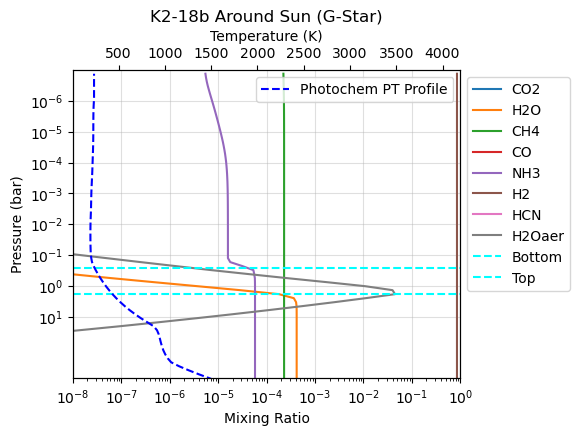

The inputs for this graph include: flux 0.1, metallicity 0.5, tint 60, kzz 7


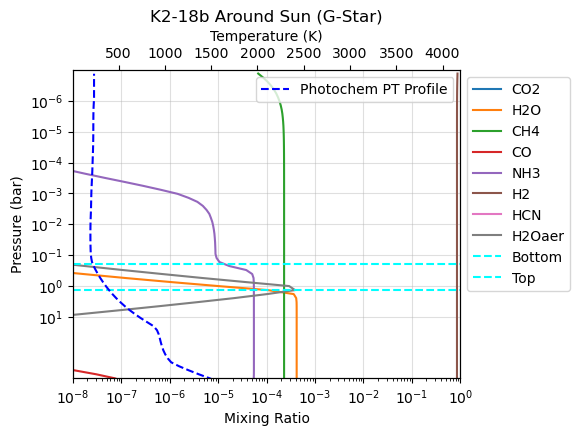

The inputs for this graph include: flux 0.1, metallicity 0.5, tint 120, kzz 7


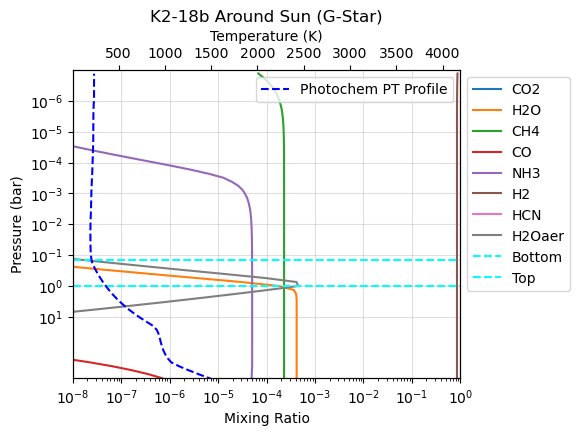

The inputs for this graph include: flux 0.1, metallicity 0.5, tint 160, kzz 5


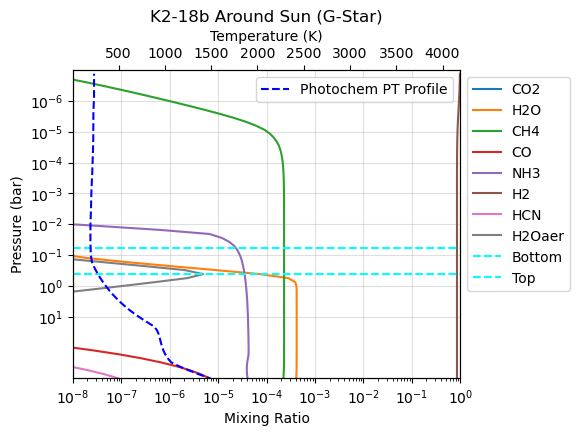

The inputs for this graph include: flux 0.1, metallicity 1.0, tint 20, kzz 5


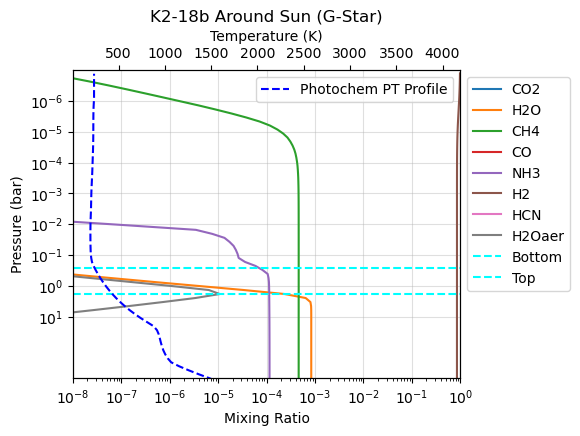

The inputs for this graph include: flux 0.1, metallicity 1.0, tint 40, kzz 9


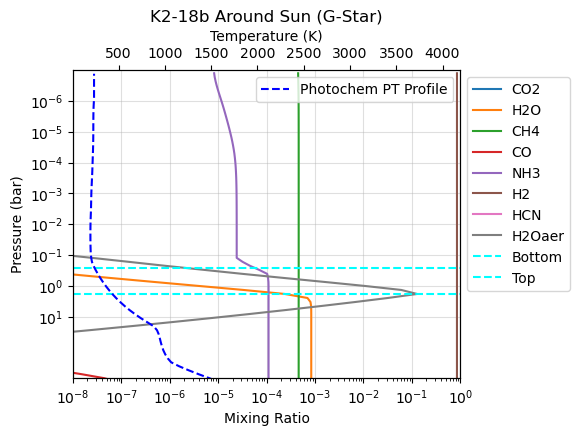

The inputs for this graph include: flux 0.1, metallicity 1.0, tint 100, kzz 9


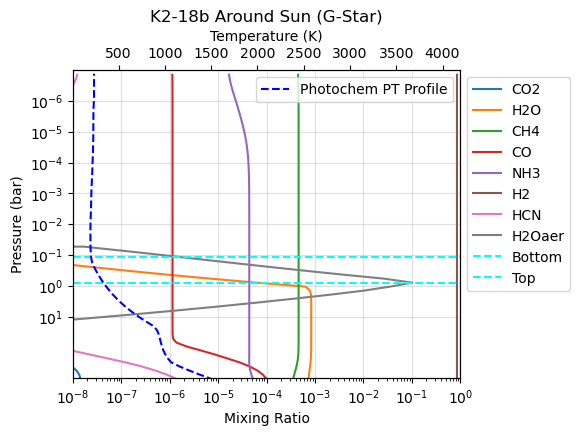

The inputs for this graph include: flux 0.1, metallicity 1.0, tint 140, kzz 9


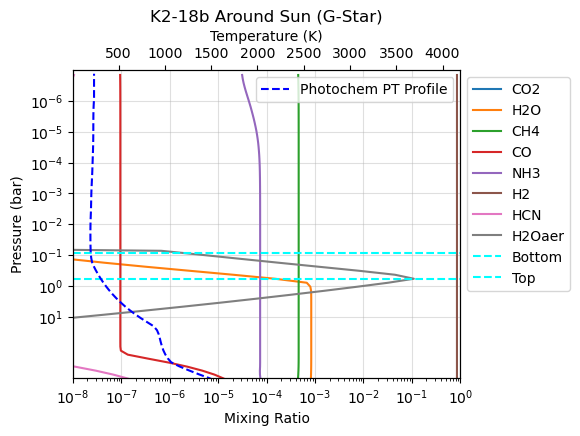

The inputs for this graph include: flux 0.1, metallicity 1.0, tint 200, kzz 7


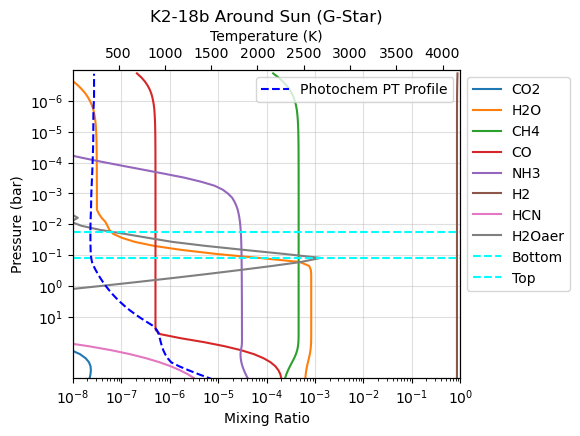

The inputs for this graph include: flux 0.1, metallicity 1.5, tint 40, kzz 7


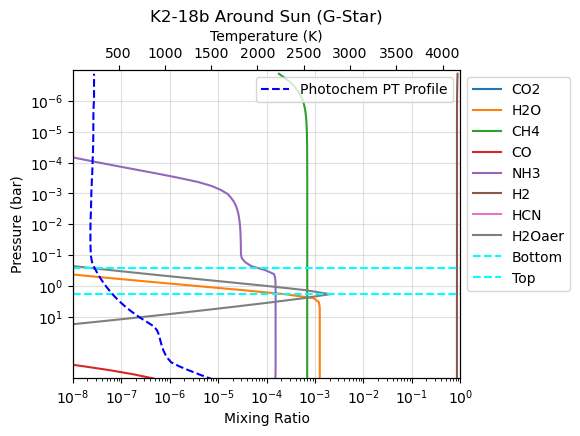

The inputs for this graph include: flux 0.1, metallicity 1.5, tint 100, kzz 5


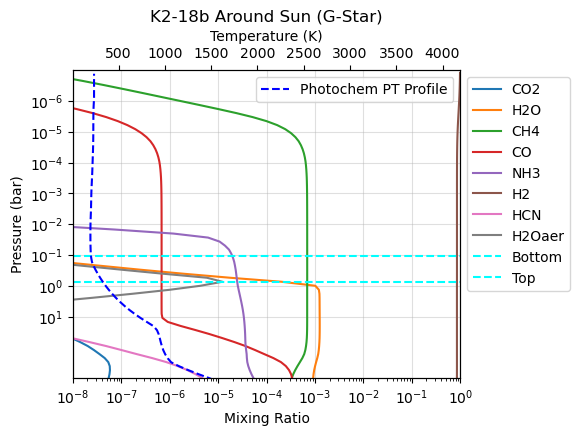

The inputs for this graph include: flux 0.1, metallicity 1.5, tint 140, kzz 5


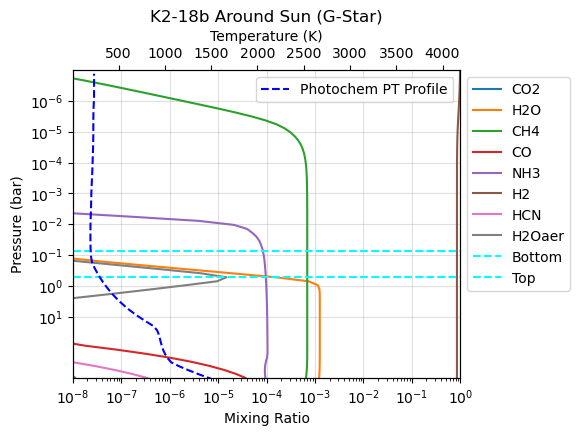

The inputs for this graph include: flux 0.1, metallicity 1.5, tint 160, kzz 9


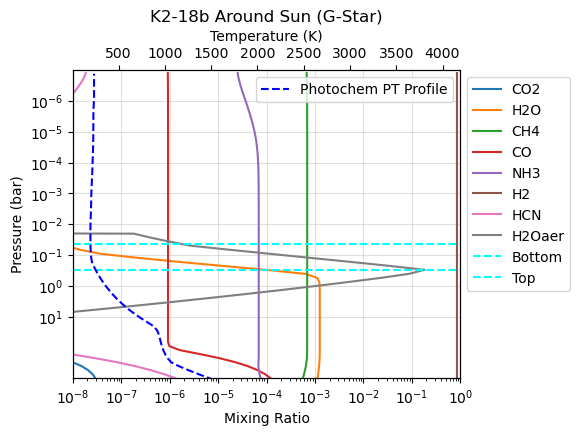

The inputs for this graph include: flux 0.1, metallicity 2.0, tint 20, kzz 9


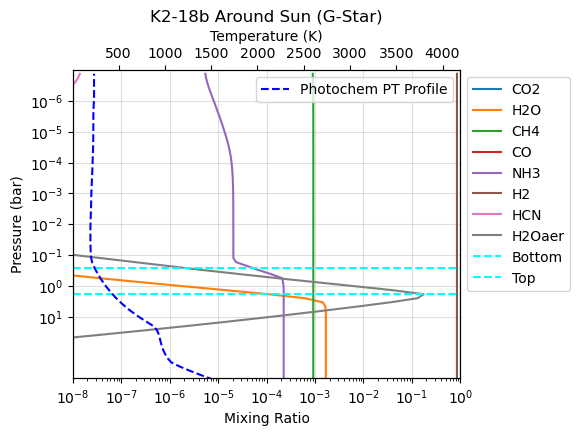

The inputs for this graph include: flux 0.1, metallicity 2.0, tint 60, kzz 7


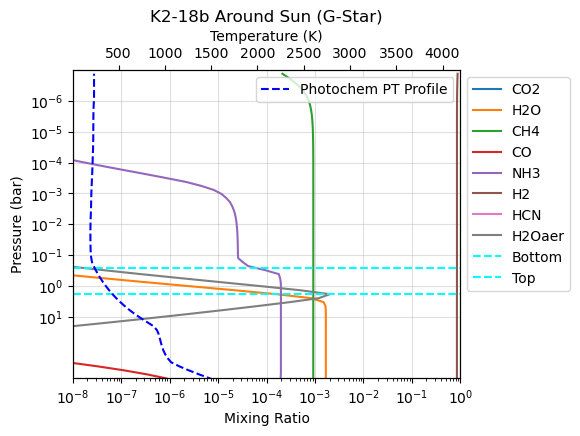

The inputs for this graph include: flux 0.1, metallicity 2.0, tint 120, kzz 7


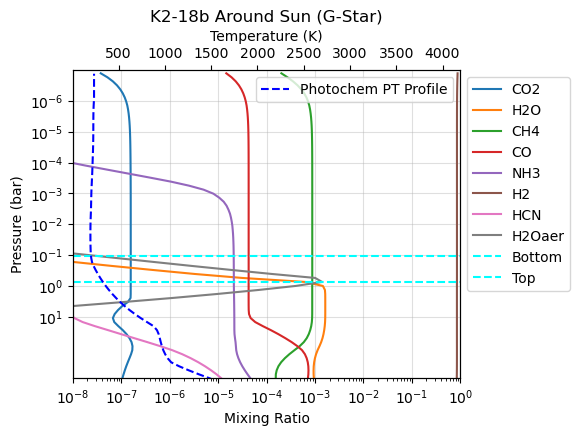

The inputs for this graph include: flux 0.1, metallicity 2.0, tint 160, kzz 7


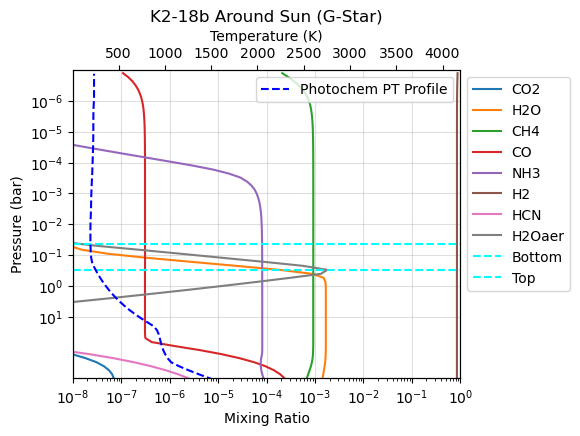

The inputs for this graph include: flux 0.5, metallicity 0.5, tint 20, kzz 5


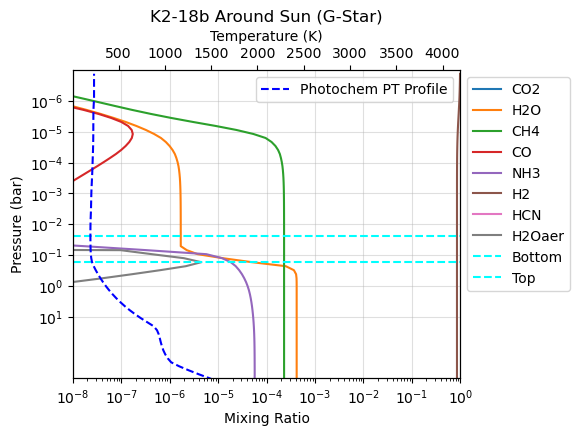

The inputs for this graph include: flux 0.5, metallicity 0.5, tint 60, kzz 5


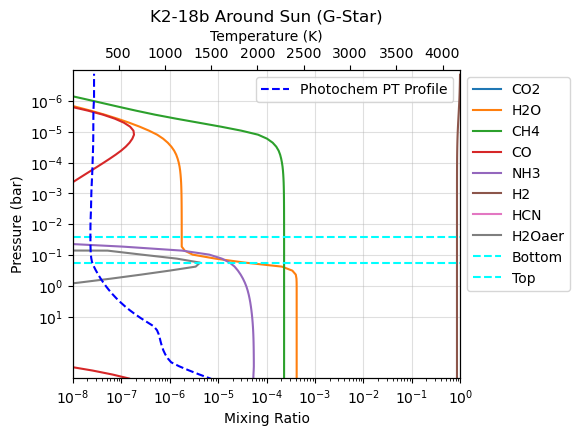

The inputs for this graph include: flux 0.5, metallicity 0.5, tint 100, kzz 9


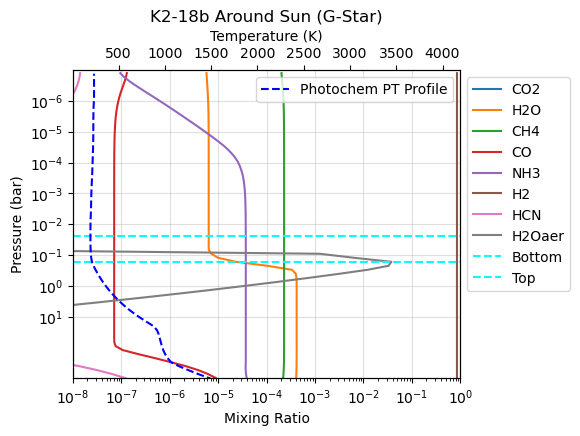

The inputs for this graph include: flux 0.5, metallicity 0.5, tint 140, kzz 9


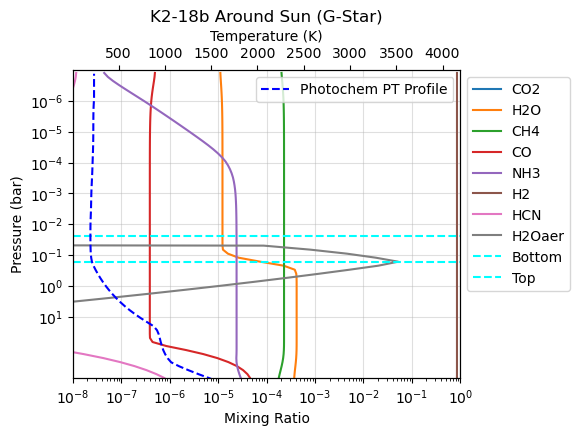

The inputs for this graph include: flux 0.5, metallicity 0.5, tint 200, kzz 7


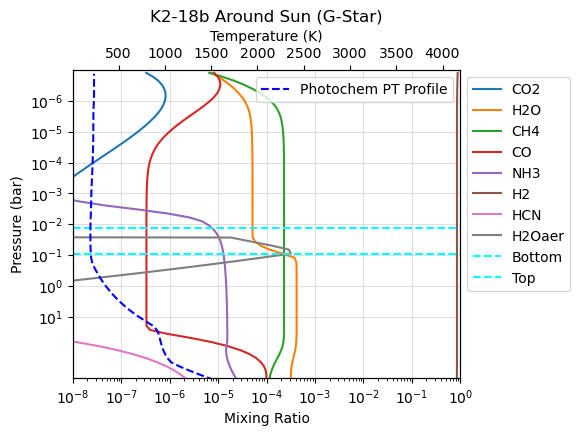

The inputs for this graph include: flux 0.5, metallicity 1.0, tint 40, kzz 7


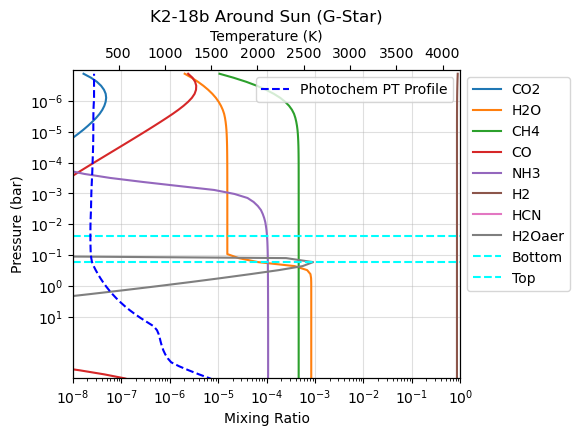

The inputs for this graph include: flux 0.5, metallicity 1.0, tint 100, kzz 5


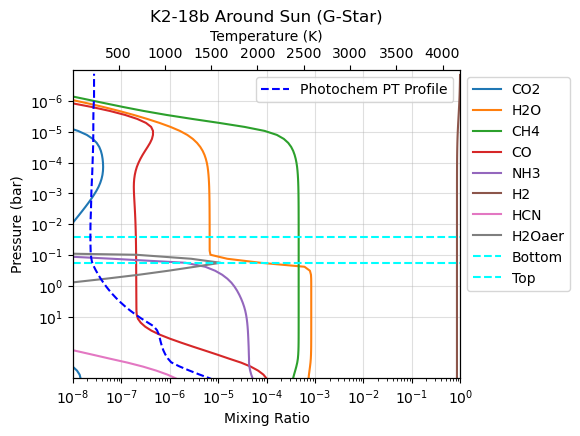

The inputs for this graph include: flux 0.5, metallicity 1.0, tint 140, kzz 5


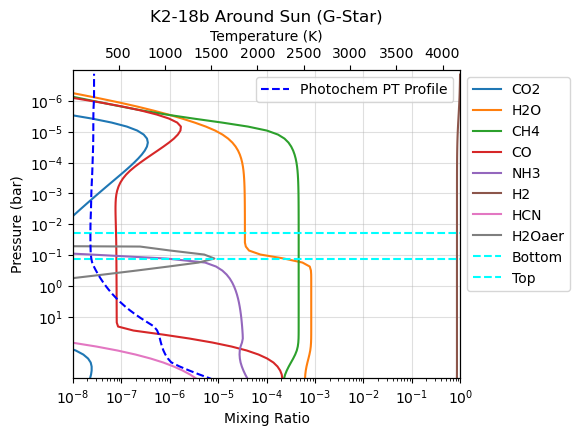

The inputs for this graph include: flux 0.5, metallicity 1.0, tint 200, kzz 5


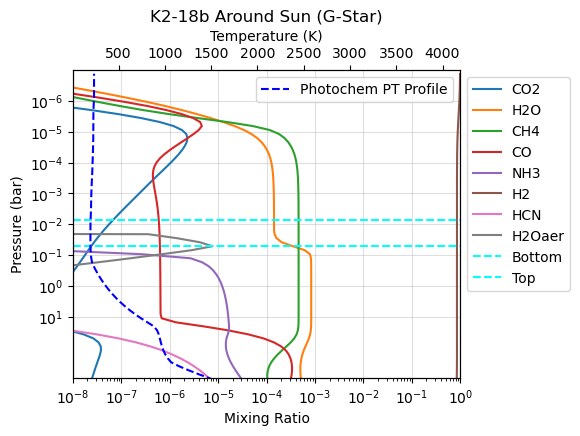

The inputs for this graph include: flux 0.5, metallicity 1.5, tint 20, kzz 9


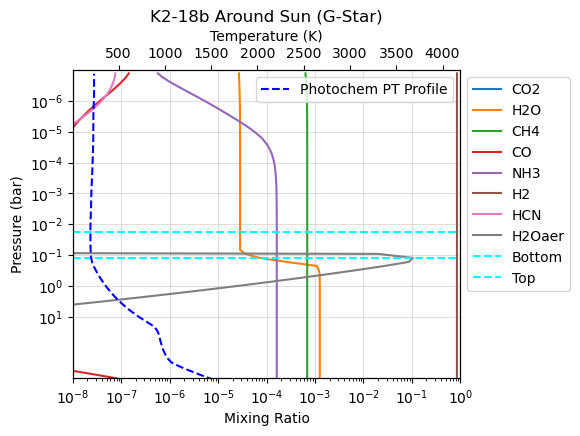

The inputs for this graph include: flux 0.5, metallicity 1.5, tint 60, kzz 9


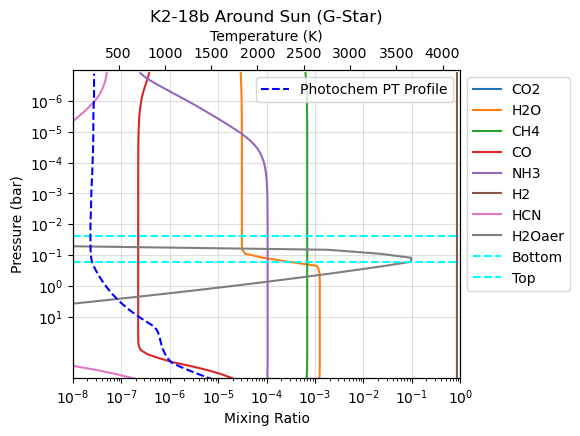

The inputs for this graph include: flux 0.5, metallicity 1.5, tint 120, kzz 7


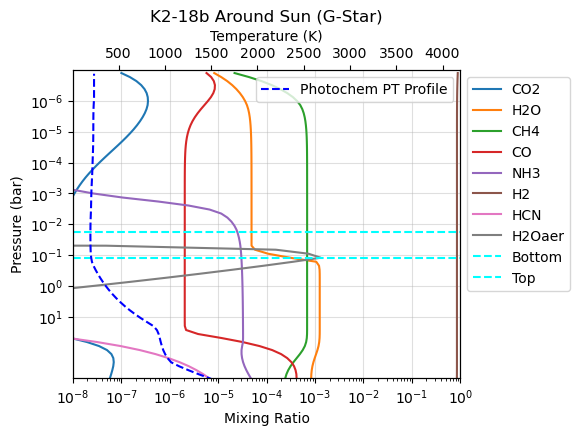

The inputs for this graph include: flux 0.5, metallicity 1.5, tint 160, kzz 7


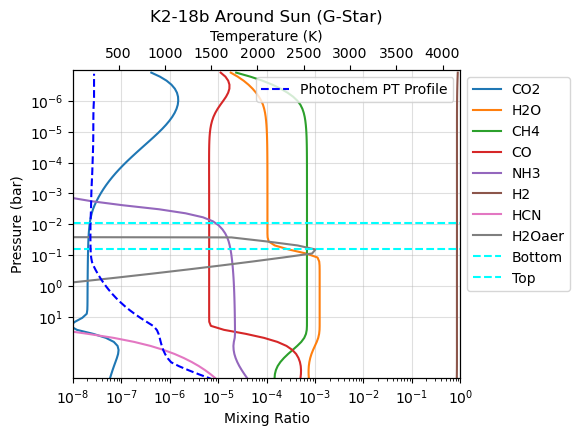

The inputs for this graph include: flux 0.5, metallicity 2.0, tint 20, kzz 5


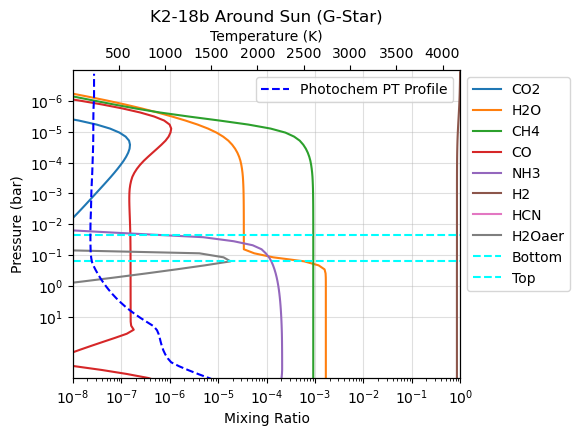

The inputs for this graph include: flux 0.5, metallicity 2.0, tint 60, kzz 5


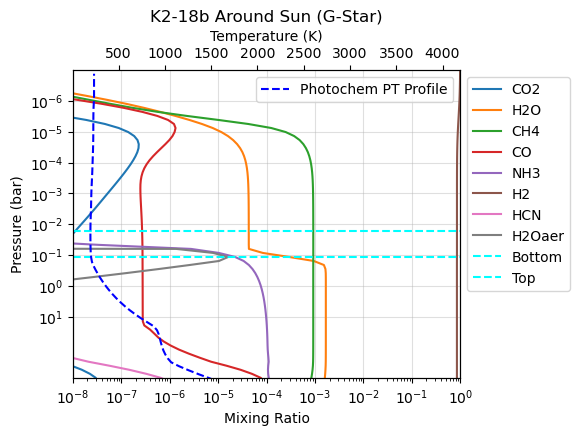

The inputs for this graph include: flux 0.5, metallicity 2.0, tint 100, kzz 9


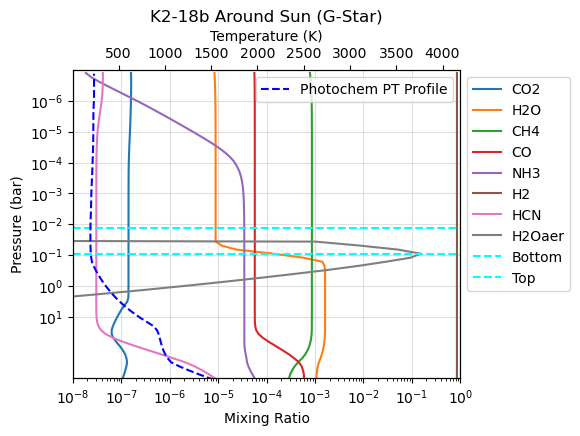

The inputs for this graph include: flux 0.5, metallicity 2.0, tint 140, kzz 9


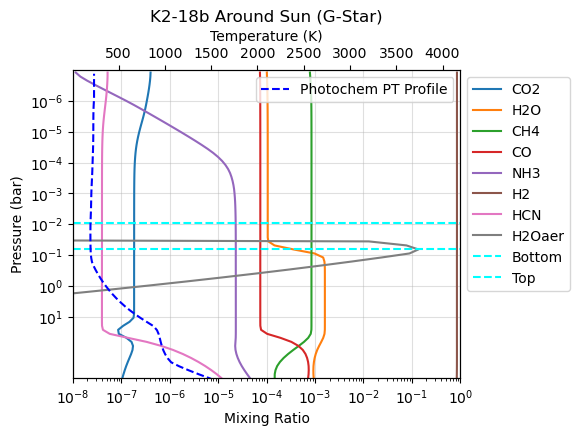

The inputs for this graph include: flux 0.5, metallicity 2.0, tint 200, kzz 9


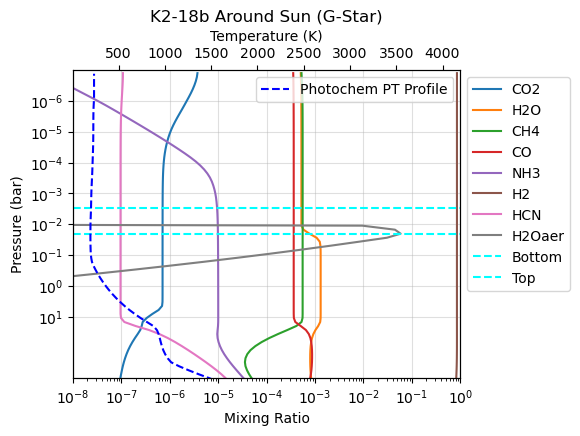

In [6]:
matching_indicies_clouds_cutdown = matching_indicies_clouds[19::20]
test_index_cases = matching_indicies_clouds_cutdown[1::5] # Cuts down to 15 random cases

assos_values = matching_values_clouds[19::20]
test_assos_values = assos_values[1::5] # Cuts down to 15 random cases

index_list = np.linspace(0, len(test_index_cases) - 1, len(test_index_cases), dtype=int)

for indicies in index_list:

    flux_index = test_index_cases[indicies][0]
    metal_index = test_index_cases[indicies][1]
    tint_index = test_index_cases[indicies][2]
    kzz_index = test_index_cases[indicies][3]
    phase_index = test_index_cases[indicies][4]

    input_value = test_assos_values[indicies]

    print(f'The inputs for this graph include: flux {input_value[0]}, metallicity {input_value[1]}, tint {input_value[2]}, kzz {input_value[3]}')

    plot_cloud(sol_dict=sol_dict, flux_index=flux_index, metal_index=metal_index, tint_index=tint_index, kzz_index=kzz_index)

### Checks some random cases without clouds 

In [7]:
filename='results/ReflectedSpectra_fv.h5'
gridvals=Reflected_Spectra.get_gridvals_RSM()

gridvals_metal = [float(s) for s in gridvals[1]]
gridvals_dict = {'total_flux':gridvals[0], 'planet_metallicity':np.array(gridvals_metal), 'tint':gridvals[2], 'kzz':gridvals[3], 'phase':gridvals[4]}
index_flux = np.linspace(0, len(gridvals_dict['total_flux']) - 1, len(gridvals_dict['total_flux']), dtype=int)
print(gridvals_dict['total_flux'], index_flux)
index_metal = np.linspace(0, len(gridvals_dict['planet_metallicity']) - 1, len(gridvals_dict['planet_metallicity']), dtype=int)
print(gridvals_dict['planet_metallicity'], index_metal)
index_tint = np.linspace(0, len(gridvals_dict['tint']) - 1, len(gridvals_dict['tint']), dtype=int)
print(gridvals_dict['tint'], index_tint)
index_kzz = np.linspace(0, len(gridvals_dict['kzz']) - 1, len(gridvals_dict['kzz']), dtype=int)
print(gridvals_dict['kzz'], index_kzz)
index_phase = np.linspace(0, len(gridvals_dict['phase']) - 1, len(gridvals_dict['phase']), dtype=int)
print(gridvals_dict['phase'], index_phase)
true_converg_list = np.array([0])
matching_indicies_no_clouds = []
matching_values_no_clouds = []

with h5py.File(filename, 'r') as f:
    
    for flux in index_flux:
        for metal in index_metal:
            for tint in index_tint:
                for kzz in index_kzz:
                    for phase in index_phase:
                        if np.array(list(f['results']['clouds'][flux][metal][tint][kzz][phase]))[0] == true_converg_list:
                            index = np.array([flux, metal, tint, kzz, phase])
                            matching_indicies_no_clouds.append(index)

    for array in matching_indicies_no_clouds:
        flux_index = array[0]
        metal_index = array[1]
        tint_index = array[2]
        kzz_index = array[3]
        phase_index = array[4]
        flux_value = gridvals_dict['total_flux'][flux_index]
        metal_value = gridvals_dict['planet_metallicity'][metal_index]
        tint_value = gridvals_dict['tint'][tint_index]
        kzz_value = gridvals_dict['kzz'][kzz_index]
        phase_value = gridvals_dict['phase'][phase_index]
        list_value = [flux_value, metal_value, tint_value, kzz_value, phase_value]
        matching_values_no_clouds.append(list_value)
        
    
    print(len(matching_indicies_no_clouds), len(matching_values_no_clouds))

    # Just to check that all values found were actually non-converging (=0)
    for value in matching_indicies_clouds:
        flux = np.array(value)[0]
        metal = np.array(value)[1]
        tint = np.array(value)[2]
        kzz = np.array(value)[3]
        phase = np.array(value)[4]

        if list(f['results']['clouds'][flux][metal][tint][kzz][phase])[0] == 0:
            print(f'This found the cases where clouds were NOT calculated!')
        else:
            continue

    print(f'For cases with no clouds: {len(matching_values_no_clouds)}')

[0.1 0.5 1.  1.5 2. ] [0 1 2 3 4]
[0.5 1.  1.5 2. ] [0 1 2 3]
[ 20  40  60 100 120 140 160 200] [0 1 2 3 4 5 6 7]
[5 7 9] [0 1 2]
[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
5184 5184
For cases with no clouds: 5184


52
52
The inputs for this graph include: flux 1.0, metallicity 0.5, tint 20, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


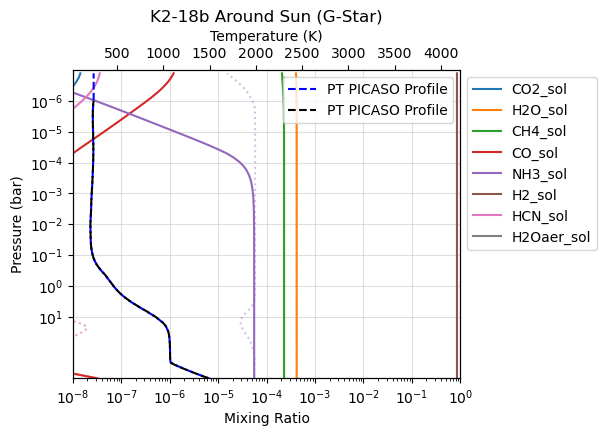

The inputs for this graph include: flux 1.0, metallicity 0.5, tint 60, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


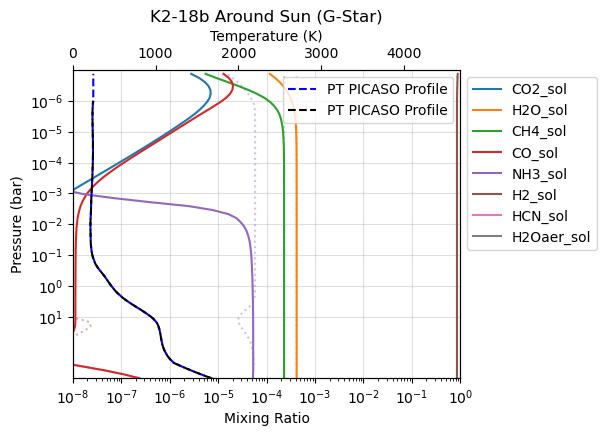

The inputs for this graph include: flux 1.0, metallicity 0.5, tint 120, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


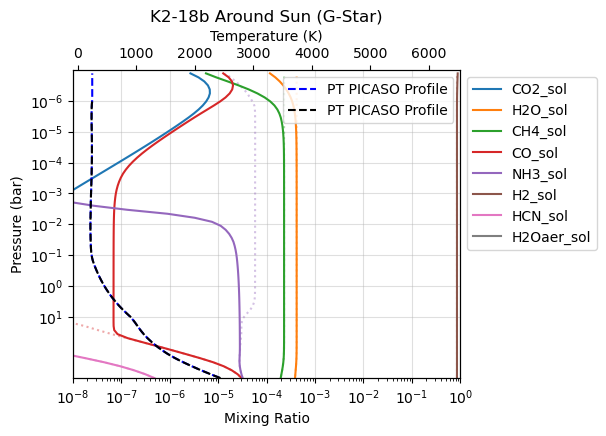

The inputs for this graph include: flux 1.0, metallicity 0.5, tint 160, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


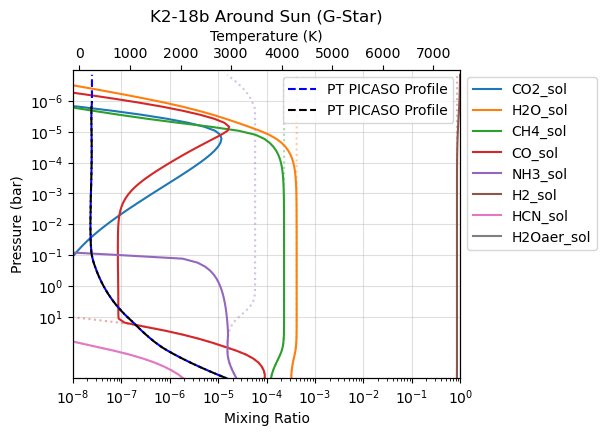

The inputs for this graph include: flux 1.0, metallicity 1.0, tint 20, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


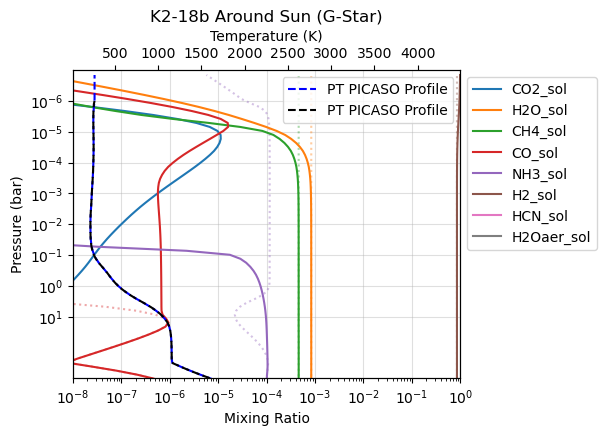

The inputs for this graph include: flux 1.0, metallicity 1.0, tint 40, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


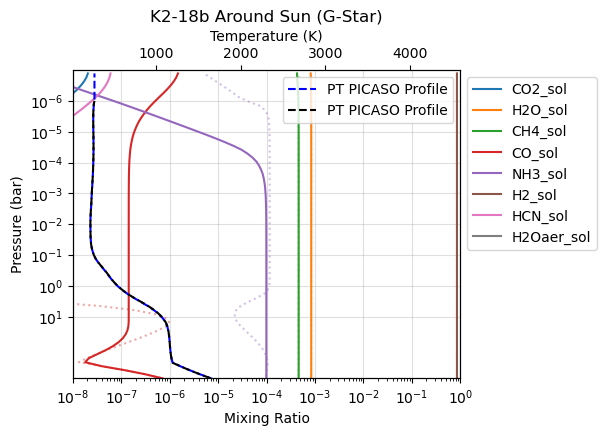

The inputs for this graph include: flux 1.0, metallicity 1.0, tint 100, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


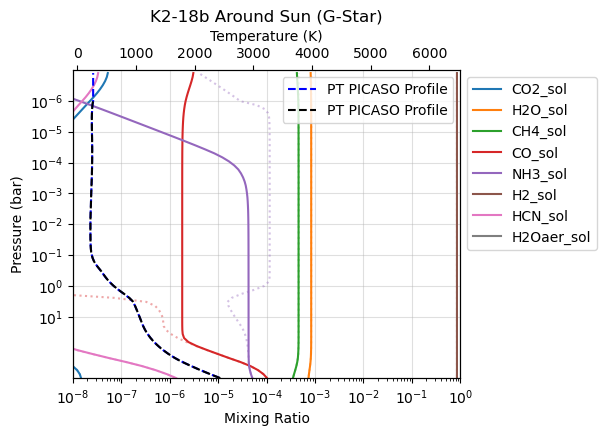

The inputs for this graph include: flux 1.0, metallicity 1.0, tint 140, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


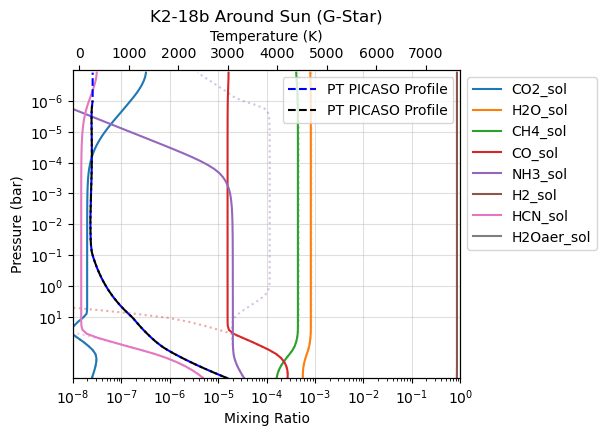

The inputs for this graph include: flux 1.0, metallicity 1.0, tint 200, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


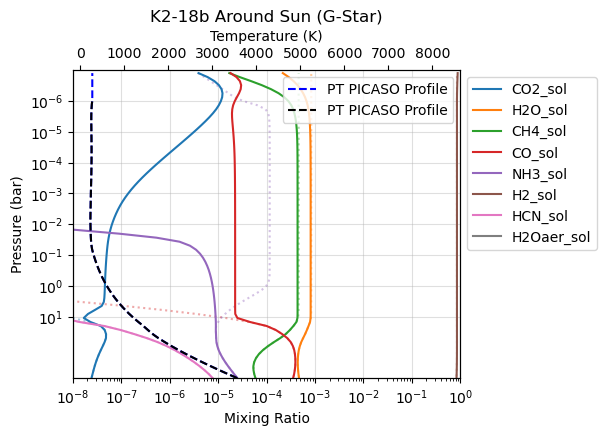

The inputs for this graph include: flux 1.0, metallicity 1.5, tint 40, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


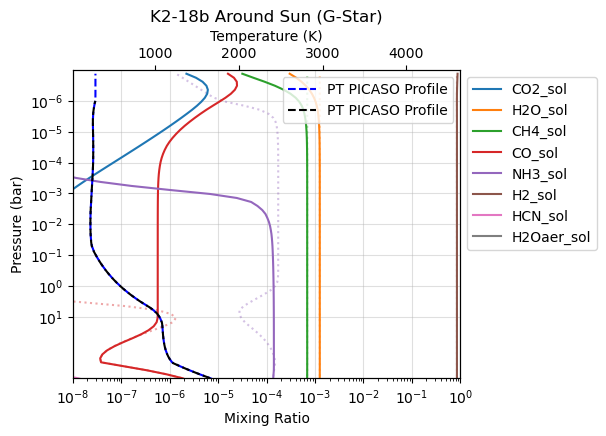

The inputs for this graph include: flux 1.0, metallicity 1.5, tint 100, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


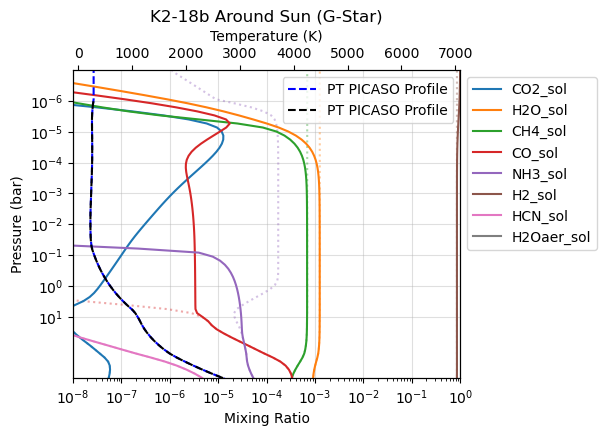

The inputs for this graph include: flux 1.0, metallicity 1.5, tint 140, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


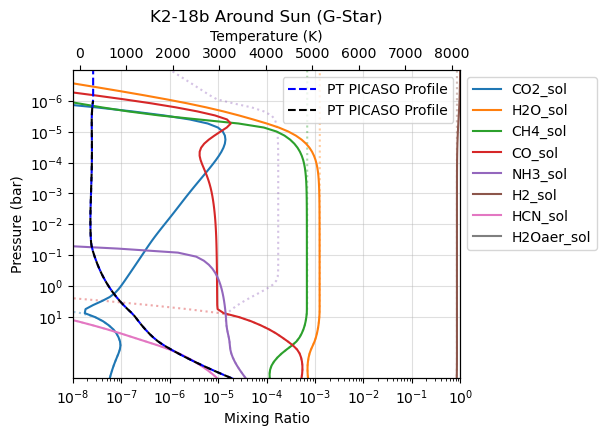

The inputs for this graph include: flux 1.0, metallicity 1.5, tint 160, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


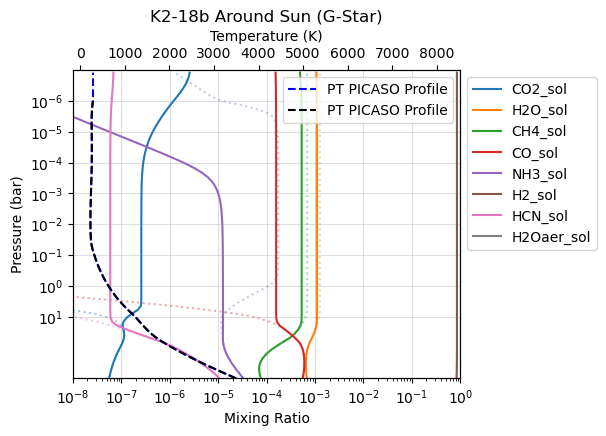

The inputs for this graph include: flux 1.0, metallicity 2.0, tint 20, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


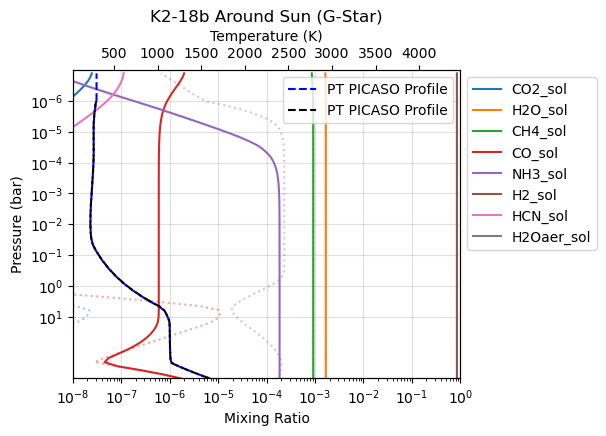

The inputs for this graph include: flux 1.0, metallicity 2.0, tint 60, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


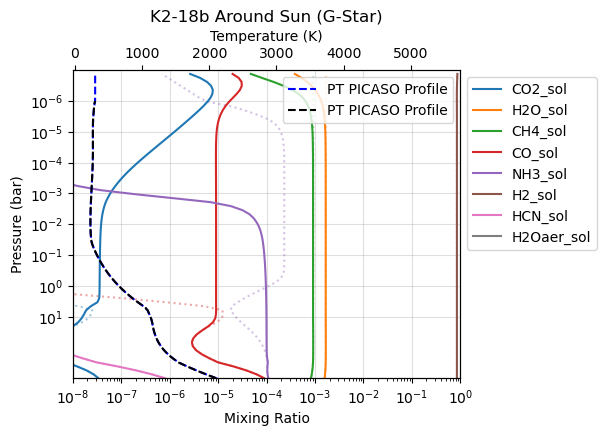

The inputs for this graph include: flux 1.0, metallicity 2.0, tint 120, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


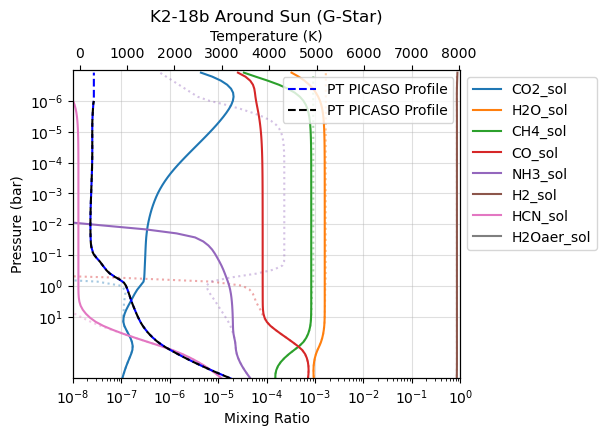

The inputs for this graph include: flux 1.0, metallicity 2.0, tint 160, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


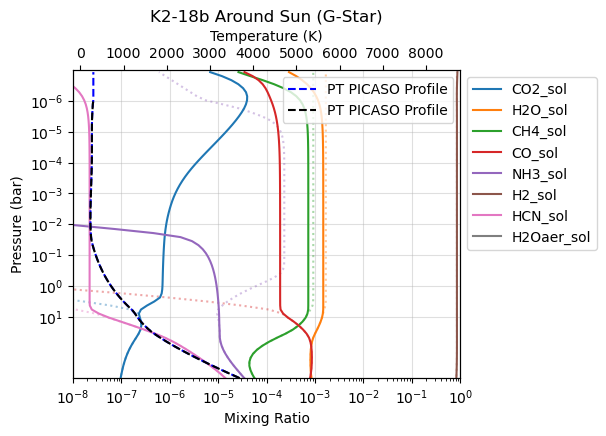

The inputs for this graph include: flux 1.5, metallicity 0.5, tint 20, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


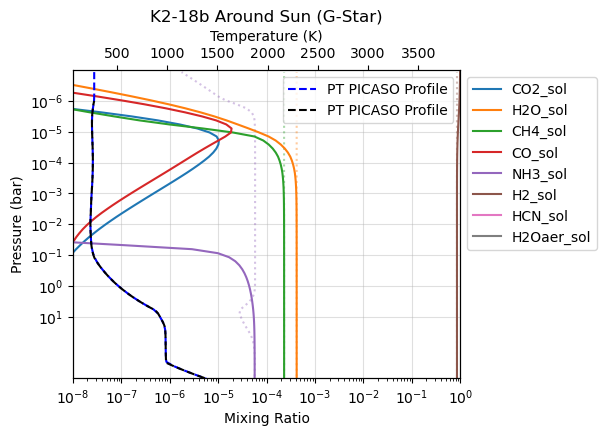

The inputs for this graph include: flux 1.5, metallicity 0.5, tint 60, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


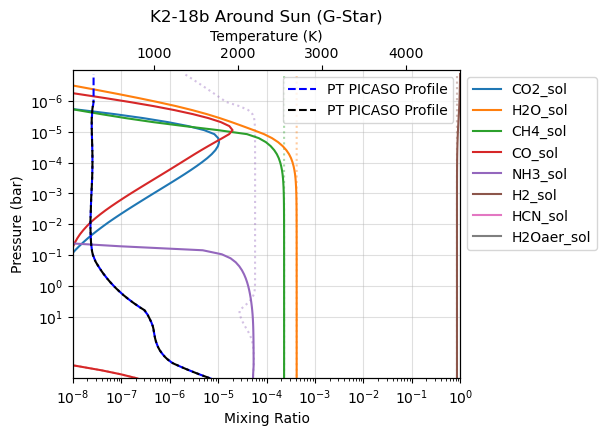

The inputs for this graph include: flux 1.5, metallicity 0.5, tint 100, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


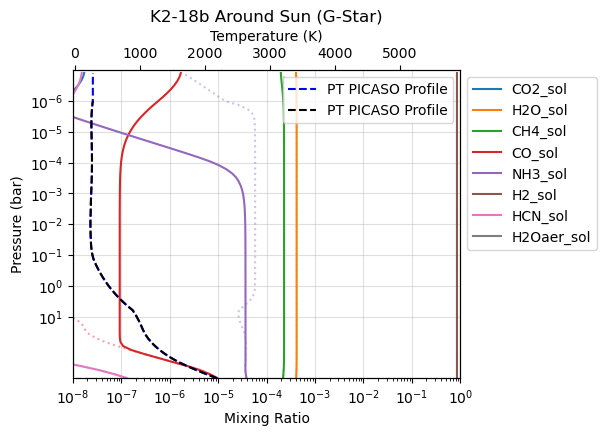

The inputs for this graph include: flux 1.5, metallicity 0.5, tint 140, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


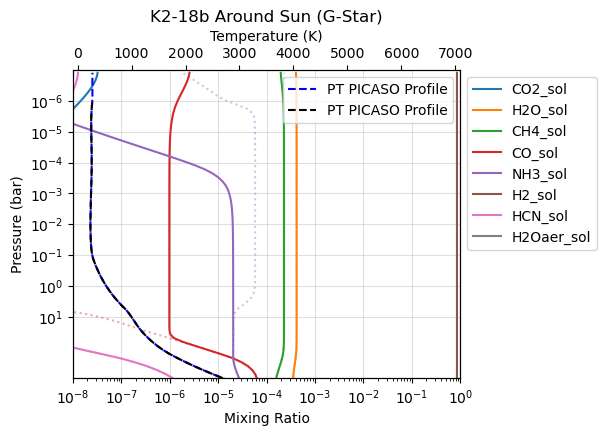

The inputs for this graph include: flux 1.5, metallicity 0.5, tint 200, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


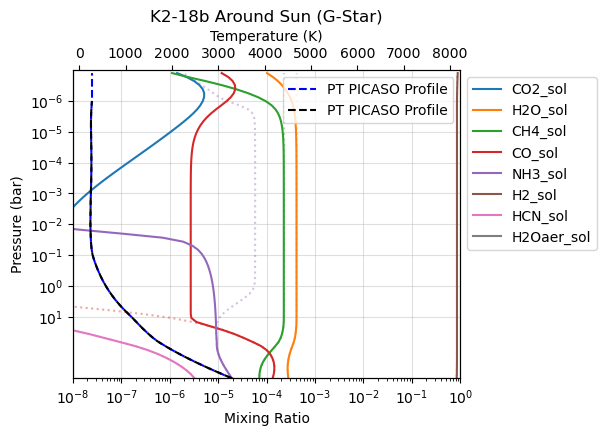

The inputs for this graph include: flux 1.5, metallicity 1.0, tint 40, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


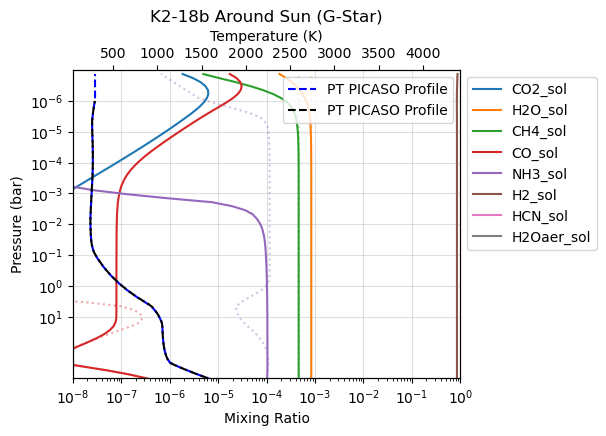

The inputs for this graph include: flux 1.5, metallicity 1.0, tint 100, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


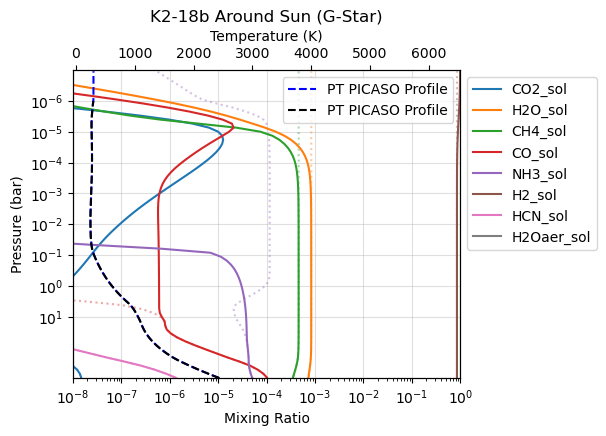

The inputs for this graph include: flux 1.5, metallicity 1.0, tint 140, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


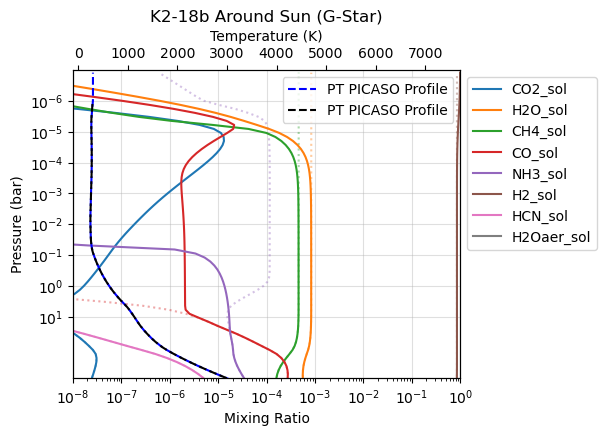

The inputs for this graph include: flux 1.5, metallicity 1.0, tint 200, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


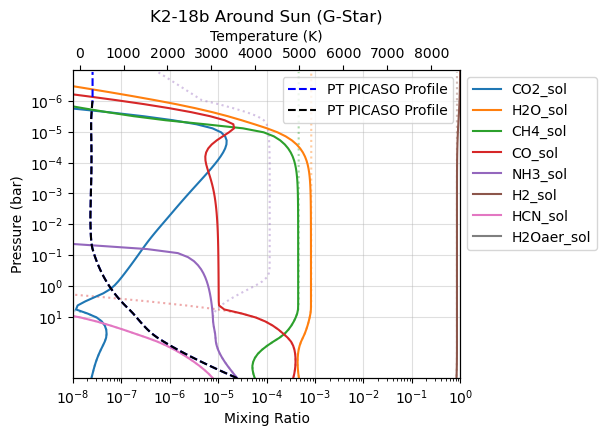

The inputs for this graph include: flux 1.5, metallicity 1.5, tint 20, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


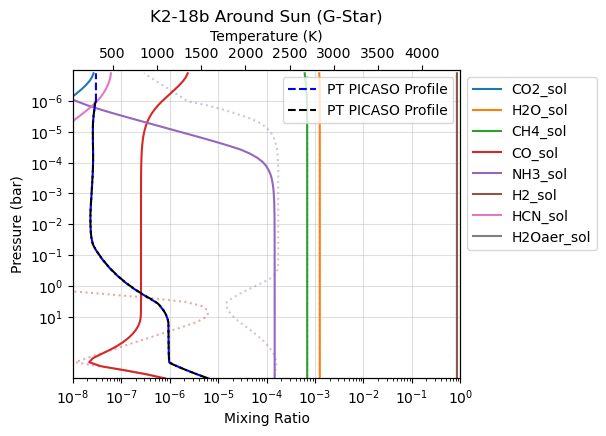

The inputs for this graph include: flux 1.5, metallicity 1.5, tint 60, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


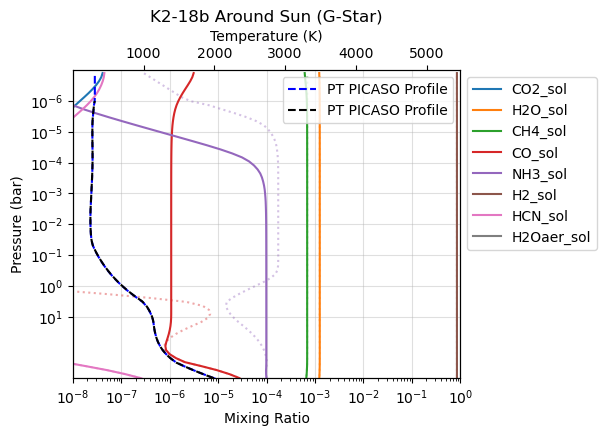

The inputs for this graph include: flux 1.5, metallicity 1.5, tint 120, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


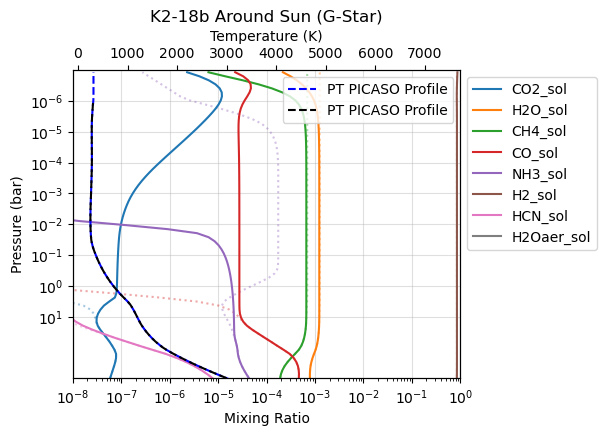

The inputs for this graph include: flux 1.5, metallicity 1.5, tint 160, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


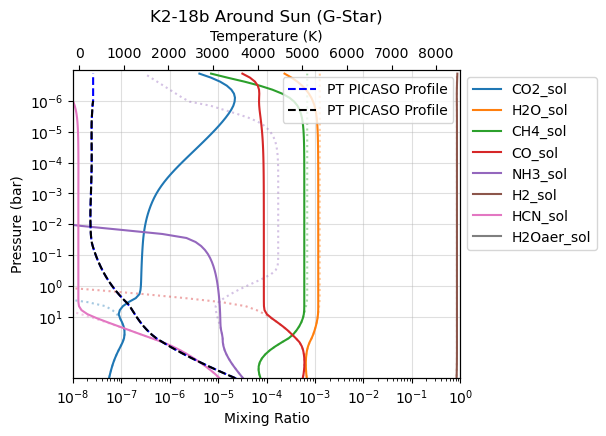

The inputs for this graph include: flux 1.5, metallicity 2.0, tint 20, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


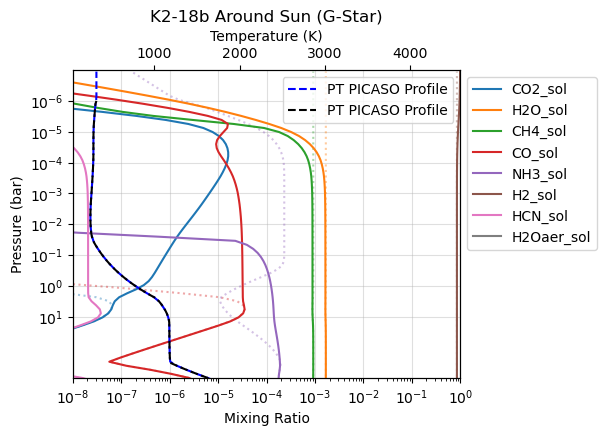

The inputs for this graph include: flux 1.5, metallicity 2.0, tint 60, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


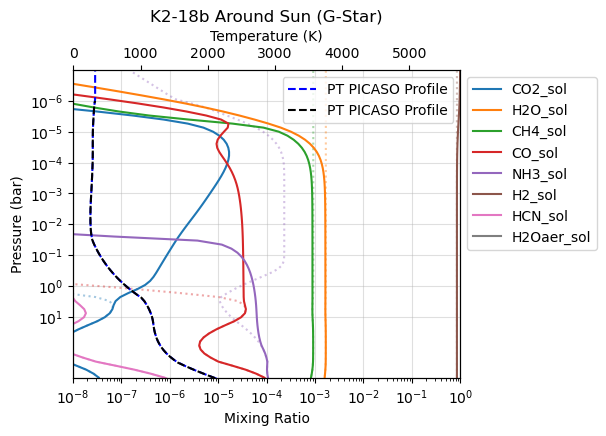

The inputs for this graph include: flux 1.5, metallicity 2.0, tint 100, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


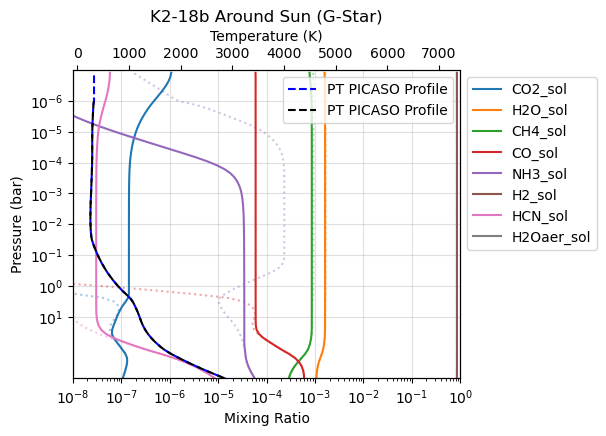

The inputs for this graph include: flux 1.5, metallicity 2.0, tint 140, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


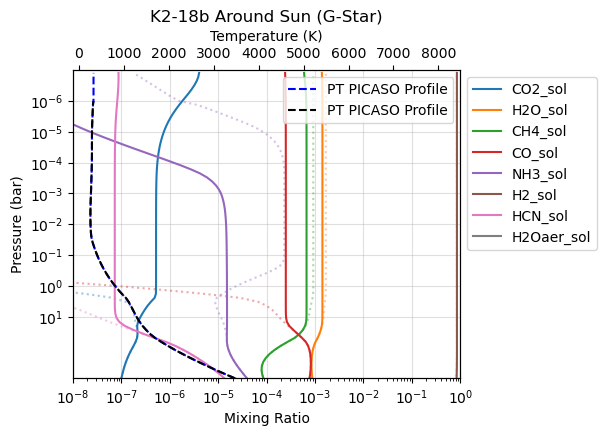

The inputs for this graph include: flux 1.5, metallicity 2.0, tint 200, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


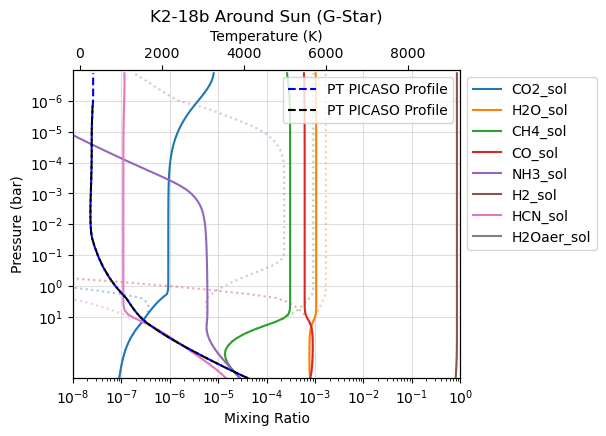

The inputs for this graph include: flux 2.0, metallicity 0.5, tint 40, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


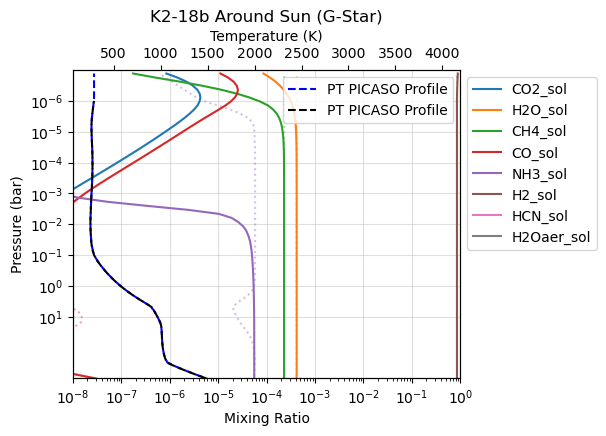

The inputs for this graph include: flux 2.0, metallicity 0.5, tint 100, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


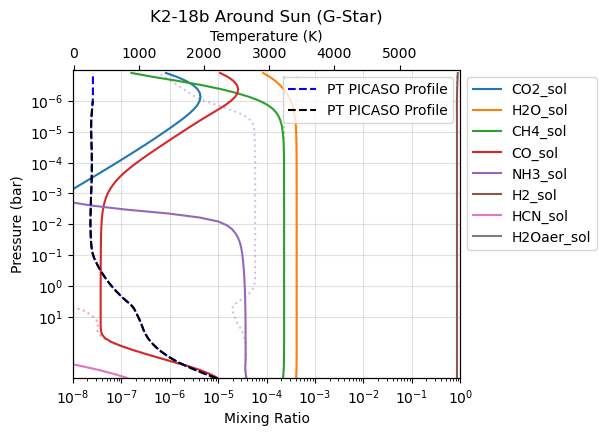

The inputs for this graph include: flux 2.0, metallicity 0.5, tint 140, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


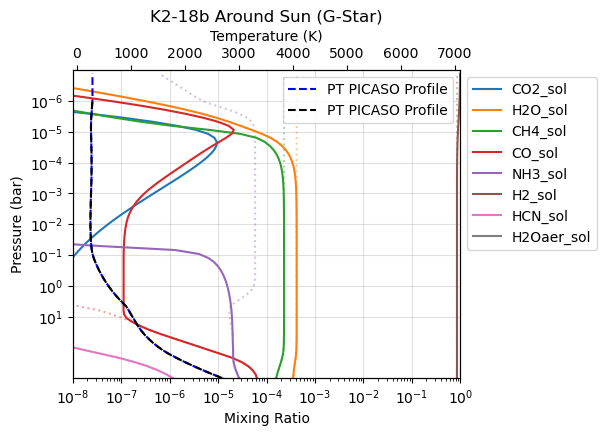

The inputs for this graph include: flux 2.0, metallicity 0.5, tint 200, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


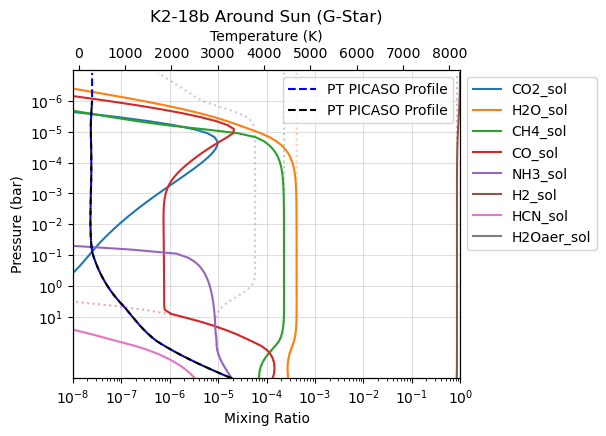

The inputs for this graph include: flux 2.0, metallicity 1.0, tint 20, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


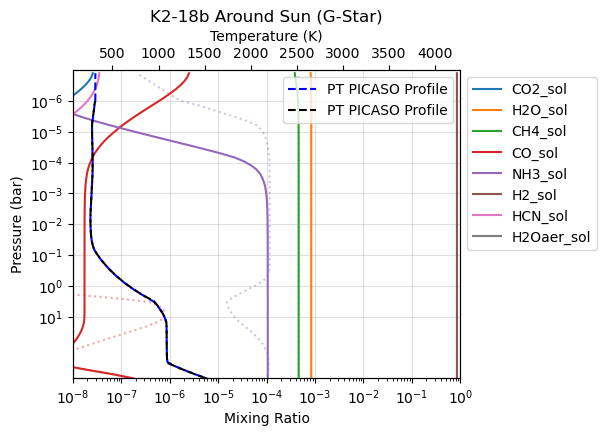

The inputs for this graph include: flux 2.0, metallicity 1.0, tint 60, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


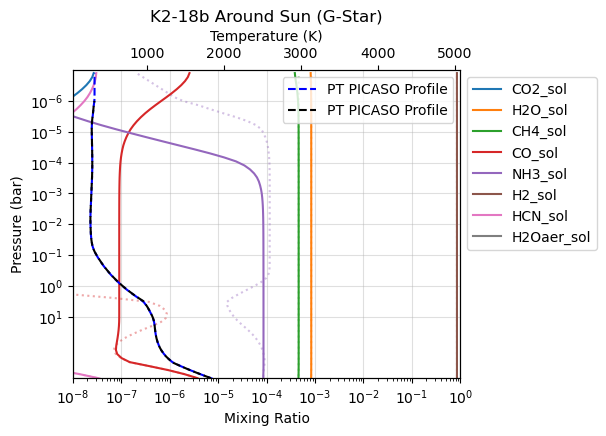

The inputs for this graph include: flux 2.0, metallicity 1.0, tint 120, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


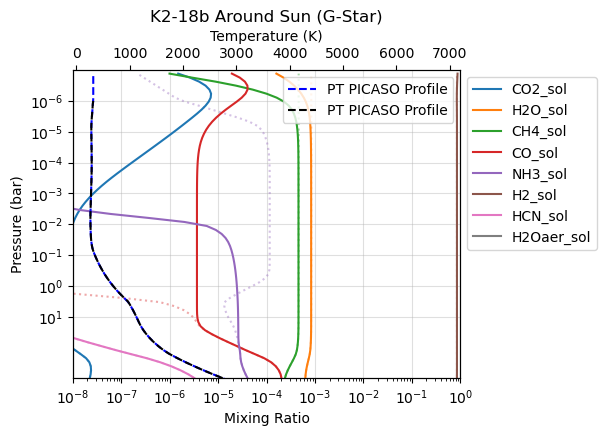

The inputs for this graph include: flux 2.0, metallicity 1.0, tint 160, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


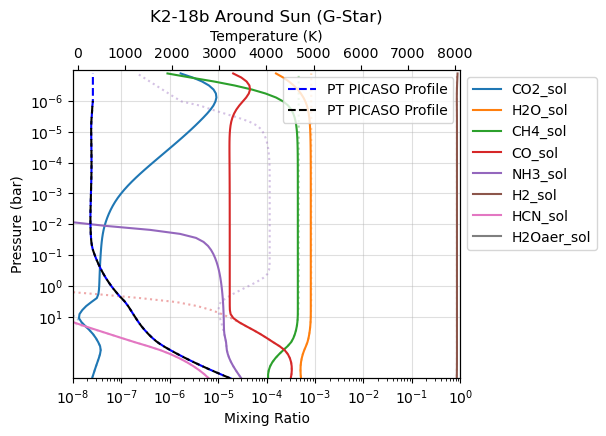

The inputs for this graph include: flux 2.0, metallicity 1.5, tint 20, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


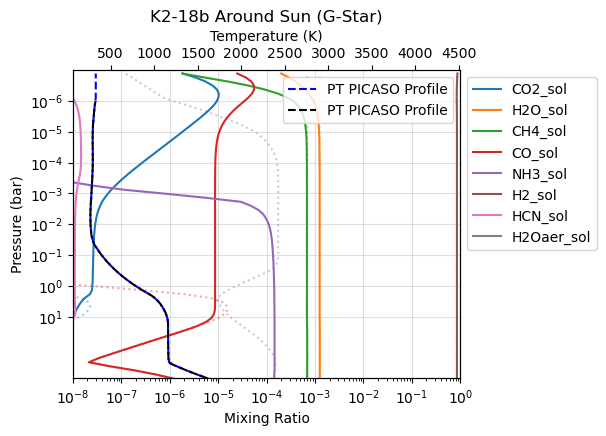

The inputs for this graph include: flux 2.0, metallicity 1.5, tint 60, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


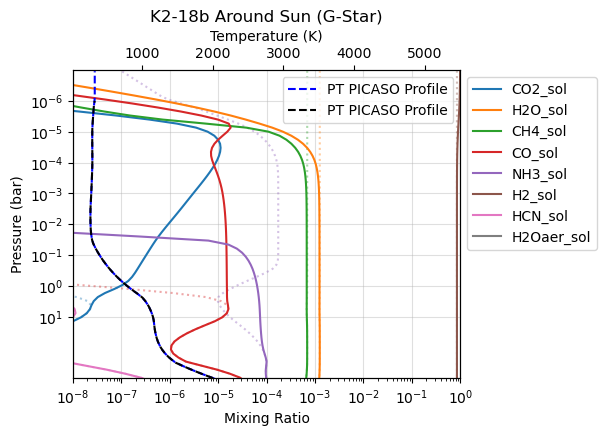

The inputs for this graph include: flux 2.0, metallicity 1.5, tint 120, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


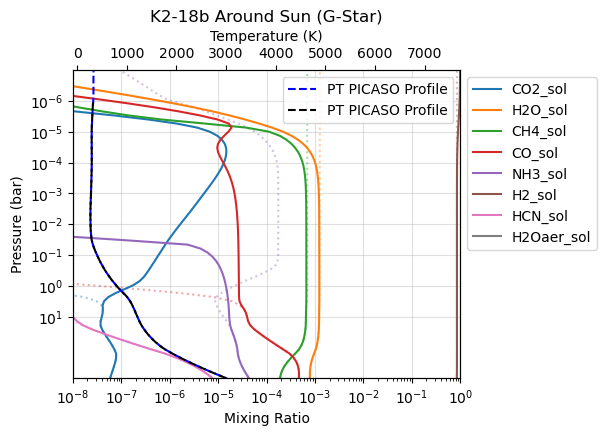

The inputs for this graph include: flux 2.0, metallicity 1.5, tint 140, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


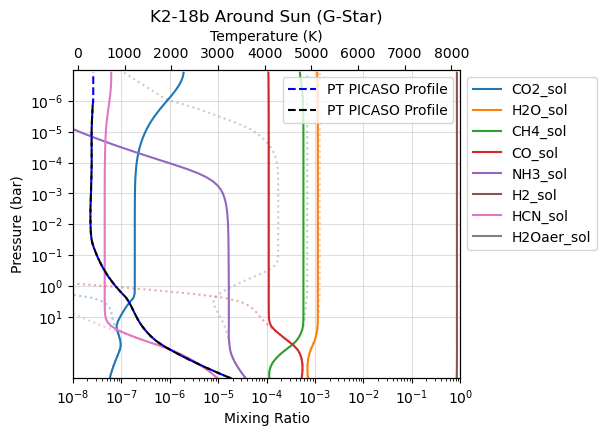

The inputs for this graph include: flux 2.0, metallicity 1.5, tint 200, kzz 9
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


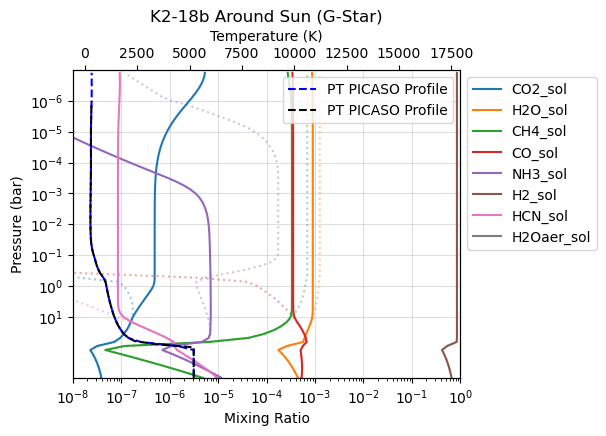

The inputs for this graph include: flux 2.0, metallicity 2.0, tint 40, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


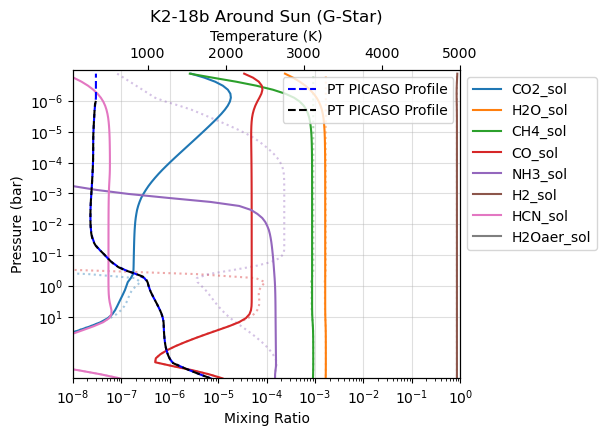

The inputs for this graph include: flux 2.0, metallicity 2.0, tint 100, kzz 7
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


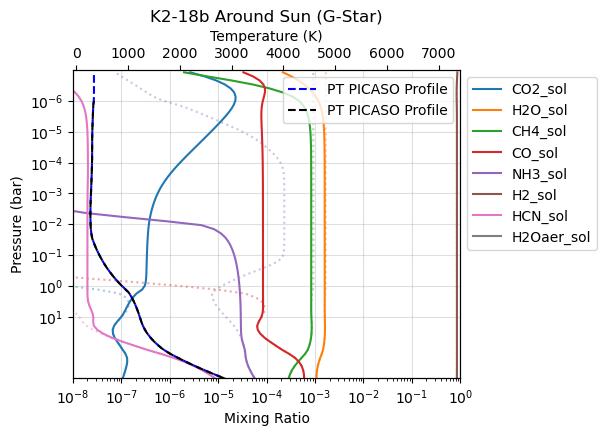

The inputs for this graph include: flux 2.0, metallicity 2.0, tint 140, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


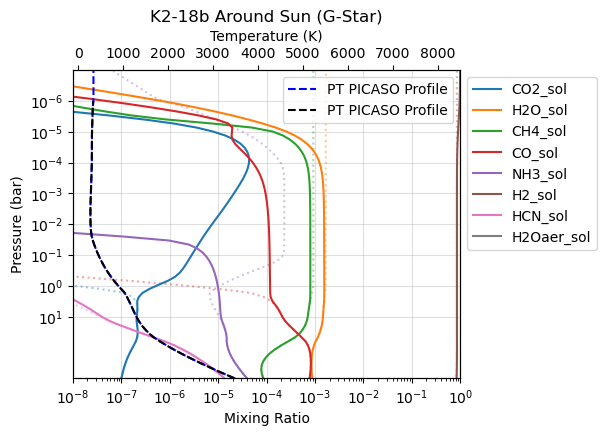

The inputs for this graph include: flux 2.0, metallicity 2.0, tint 200, kzz 5
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!
Make sure your inputs are within the following ranges, total_flux: 0.1 - 2.0 xsolar, planet metallicity: 0.5 - 2.0 xsolar, tint: 20 - 200 K, kzz: 5 - 9 log10 of cm^2/s.
Was able to successfully find your input parameters in the PICASO TP profile grid!
All inputs chosen were directly on the grid!


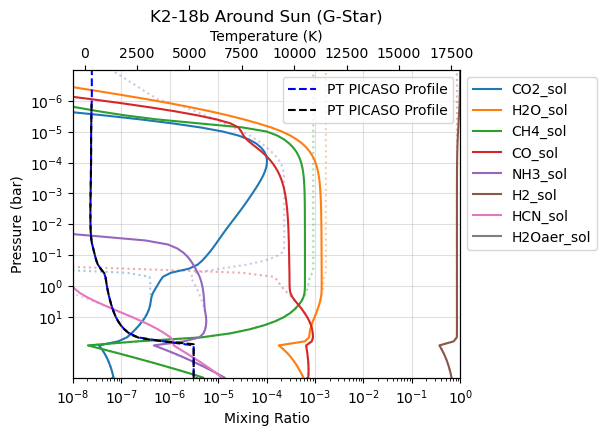

In [8]:
# Check what some of the no clouds look like
matching_indicies_no_clouds_cutdown = matching_indicies_no_clouds[19::20]
matching_indicies_no_clouds = matching_indicies_no_clouds_cutdown[1::5]

assos_values_no_clds = matching_values_no_clouds[19::20]
test_assos_values_no_clds = assos_values_no_clds[1::5] # Cuts down to 15 random cases

print(len(test_assos_values_no_clds))

print(len(matching_indicies_no_clouds))

index_list = np.linspace(0, len(matching_indicies_no_clouds) - 1, len(matching_indicies_no_clouds), dtype=int)

for indicies in index_list:

    flux_index =matching_indicies_no_clouds[indicies][0]
    metal_index = matching_indicies_no_clouds[indicies][1]
    tint_index = matching_indicies_no_clouds[indicies][2]
    kzz_index = matching_indicies_no_clouds[indicies][3]
    phase_index = matching_indicies_no_clouds[indicies][4]

    input_value = test_assos_values_no_clds[indicies]

    print(f'The inputs for this graph include: flux {input_value[0]}, metallicity {input_value[1]}, tint {input_value[2]}, kzz {input_value[3]}')

    GraphsKey.plot_PT_Photochem(total_flux=input_value[0], planet_metal=input_value[1], tint=input_value[2], kzz=input_value[3])